## <center><b>Построение модели классификации</b></center>

Решите задачу классификации для переменной `y` и сформируйте файл для `submission`. Не забывай, что твоя первая модель `baseline` - должна быть самой простой с точки зрения предобработки и настройки.

❗️ Столбец с предсказаниями в файле `submission.csv` должен называться `predict`. Если он будет называться иначе, файл не пройдет валидацию. \
❗️ Обратите внимание, что `ID` в файле `test.csv` и `submission.csv` совпадают. Решить задачу нужно для каждого конкретного `ID`.  
❗️ Старайтесь писать код аккуратно, переменные задавать понятными для вас и других названиями, чтобы в дальнейшем не запутаться.  
❗️ Все пункты, которые имеют вопросительную формулировку постарайтесь ответить. Те, которые будут иметь пометку (🔥) очень популярны на собеседованиях.  
❗️ Остальные пункты служат лишь одним из вариантов `pipeline` и некоторым ориентиром для вас. Если вы не считаете необходимым, например, отображать какой-то график или, наоборот, хотите превнести что-то свое - пожалуйста. Это ваше решение, как исследователя.

In [317]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline

# # Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# # Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# preprocessing
from sklearn.model_selection import GridSearchCV, KFold


# from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
# # Models
from sklearn.linear_model import LogisticRegression

# # Metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# # tunning hyperparamters model
import optuna

from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [318]:
# libraries
data_train = pd.read_csv("/home/adminadmin/ml-assessment/data/train.csv")
data_test = pd.read_csv("/home/adminadmin/ml-assessment/data/test.csv")
data_train.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,13829,NaN,technician,single,tertiary,no,NaN,no,no,cellular,11,NaN,2,-1,0,unknown,no
1,22677,NaN,services,single,secondary,no,NaN,yes,yes,unknown,5,NaN,3,-1,0,unknown,no
2,10541,NaN,management,single,secondary,no,NaN,no,no,cellular,14,NaN,2,-1,0,unknown,no
3,13689,NaN,technician,married,unknown,no,NaN,yes,no,cellular,10,NaN,1,-1,0,unknown,no
4,11304,NaN,admin.,single,secondary,no,NaN,no,yes,unknown,2,NaN,1,-1,0,unknown,no


* <b>Подгрузите датасет, отобразите структурную информацию</b>

In [319]:
X_train, y_train = data_train.drop('y', axis=1), data_train['y']

In [320]:
y_train = y_train.map({'yes': 1, 'no': 0})  

In [321]:
# your code
data_train.isna().sum()
len(data_train)

12870

In [322]:
data_train.shape

(12870, 17)

In [323]:
data_train.describe()

,ID,age,balance,day,campaign,pdays,previous
count,12870.000000,12282.000000,12865.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,16434.500000,41.087689,1482.854644,15.641103,2.659130,45.555478,0.688967
std,3715.393317,11.311299,3308.322822,8.368983,2.863507,104.449411,2.049696
min,10000.000000,18.000000,-6847.000000,1.000000,1.000000,-1.000000,0.000000
25%,13217.250000,32.000000,102.000000,8.000000,1.000000,-1.000000,0.000000
50%,16434.500000,39.000000,515.000000,16.000000,2.000000,-1.000000,0.000000
75%,19651.750000,49.000000,1592.000000,21.000000,3.000000,-1.000000,0.000000
max,22869.000000,95.000000,102127.000000,31.000000,43.000000,854.000000,58.000000


* Ознакомьтесь со всеми фичами и их описанием, информация есть в файле _feature_description.txt_. Погрузитесь в поставленную задачу и приступайте

### 1. Визуализация

<b>1.1 Есть числовые и категориальные данные. Какие подвиды каждого вы знаете, в чем разница их предобработки?</b>  
     

> ответ тут Непрерывные и дискретные . Категориальные. - Ординальные. Уровень владения английским а1. а2 и т.п. и номинальные(обычные)... предобработка\ числовые нужно нормализовать. категориальные обычно обрабатываем ВанХот Энкодеером


<b>1.2 С помощью чего можно отобразить распределение каждого из признаков?</b>

> ответ тут Визуализировать? для числовых БОкс плот. для категор Бар плот !

__1.3 Отобразите распределение таргета__

y
no     8903
yes    3967
Name: count, dtype: int64


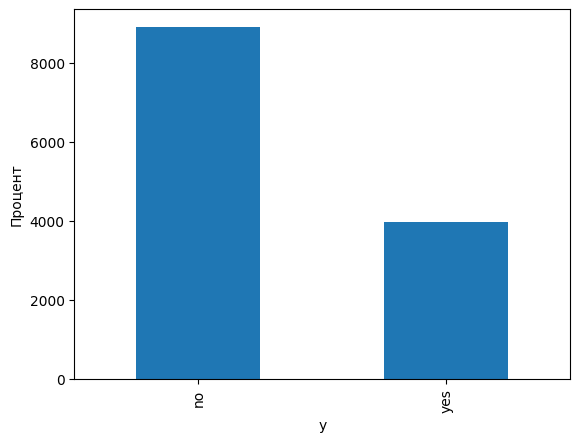

In [324]:
#your code
freq = data_train['y'].value_counts()
print(freq)  
freq.plot(kind='bar')
plt.ylabel('Процент')
plt.show()

<b>1.4 Создайте переменные <i>numeric_features, categorical_features</i>, в которые запишите название столбцов числовых и категориальных признаков</b>


In [325]:
#your code
print(data_train.dtypes)
numeric_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

ID             int64
age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
campaign       int64
pdays          int64
previous       int64
poutcome      object
y             object
dtype: object


<b>1.5 Отобразите распределения всех признаков</b> (можно в одной фигуре все числовые, в другой все категориальные)



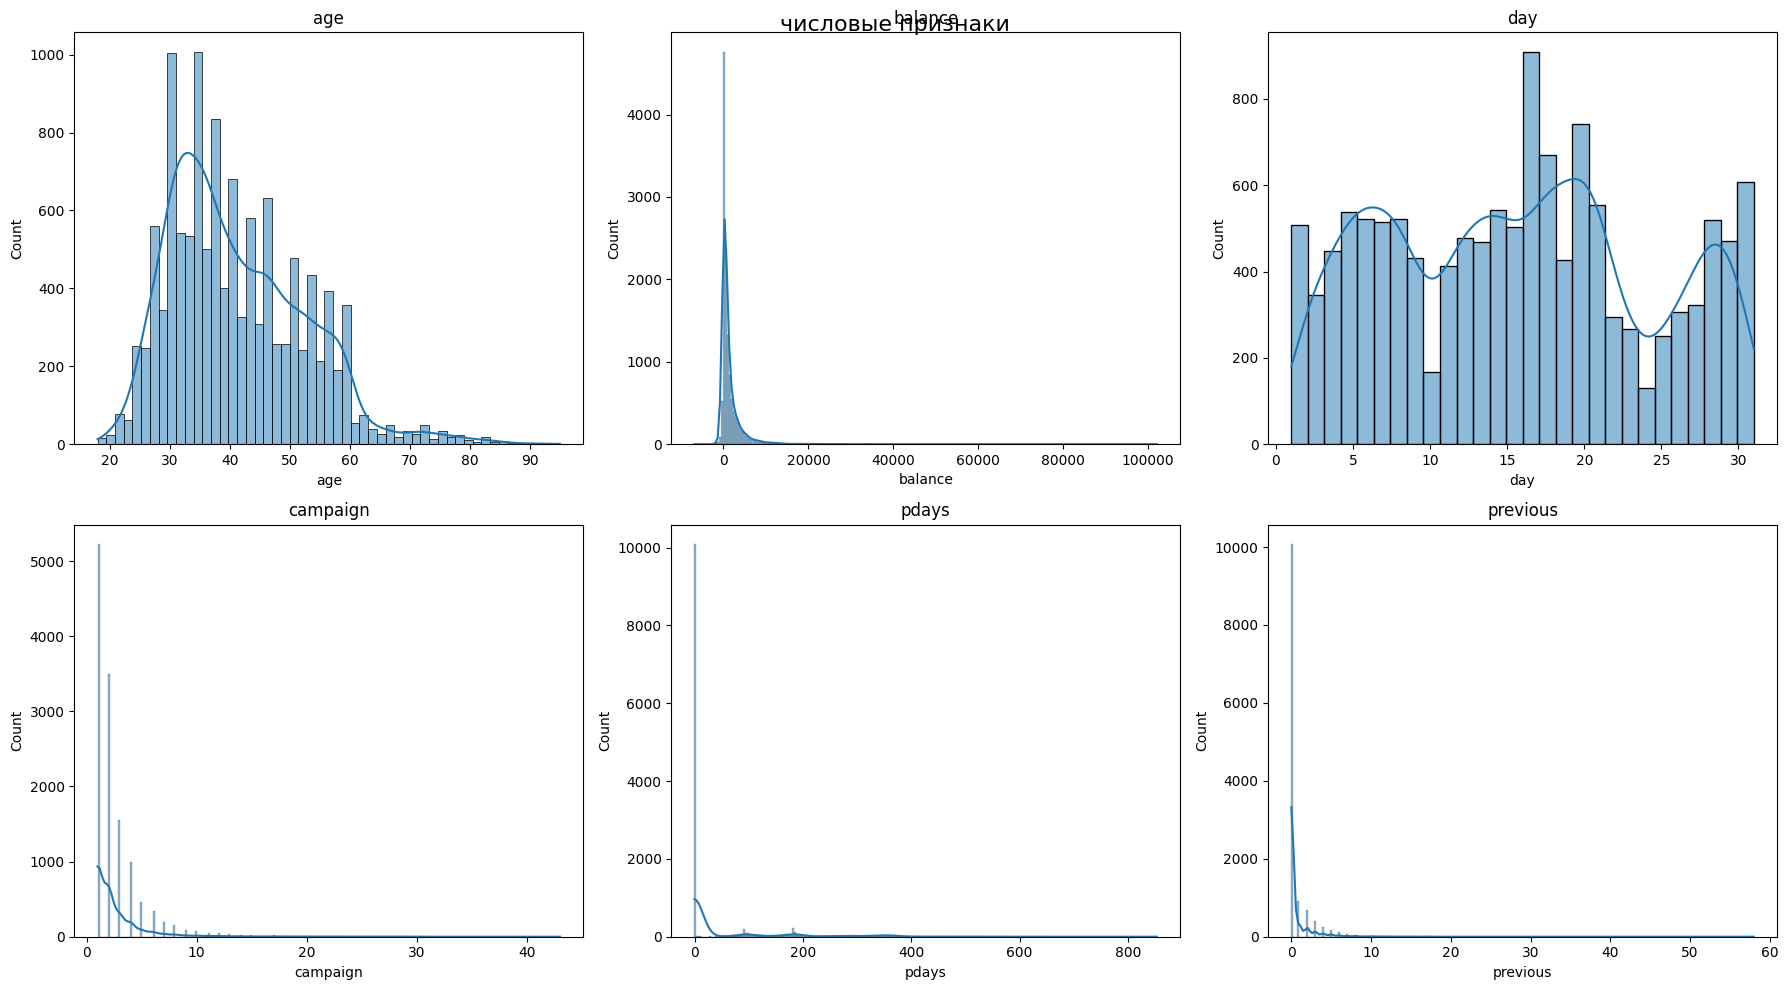

In [326]:
#your code
fig, axes = plt.subplots(2, 3, figsize=(18, 10)) 
axes = axes.flatten()  

for i, feature in enumerate(numeric_features):
    sns.histplot(data=data_train, x=feature, kde=True, ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    

plt.tight_layout()
plt.suptitle('числовые признаки', fontsize=16)
plt.show()

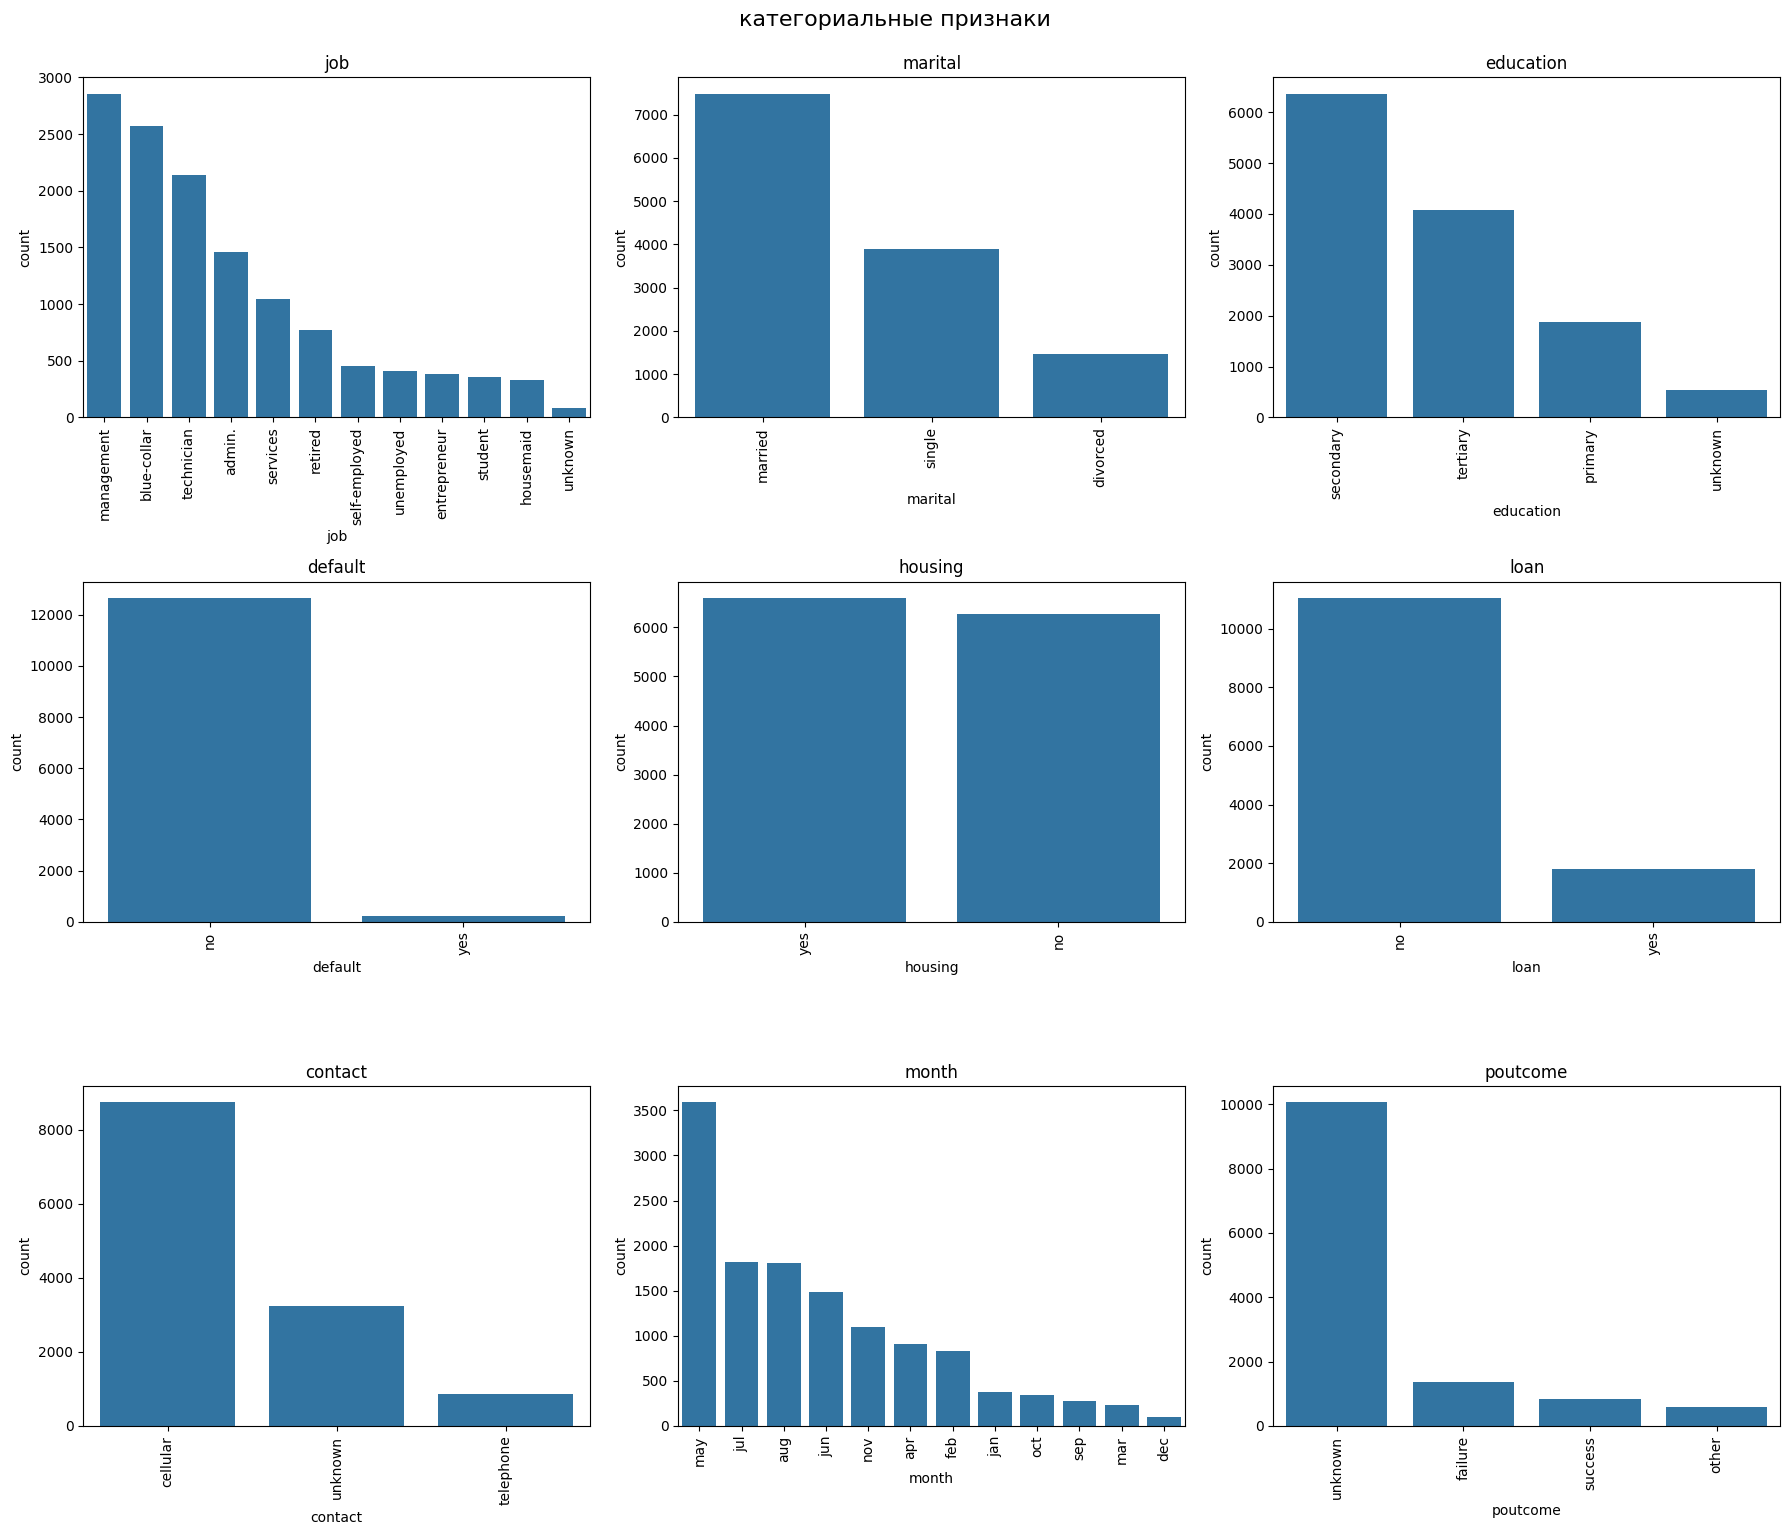

In [327]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  
axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    sns.countplot(data=data_train, x=feature, ax=axes[i], order=data_train[feature].value_counts().index)
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].tick_params(axis='x', rotation=90)  

plt.tight_layout()
plt.suptitle('категориальные признаки', fontsize=16, y=1.02)
plt.show()

 <b>1.6 Попробуйте графически подчеркнуть зависимости</b> (матрицы корреляций, боксплоты, скаттерплоты и тд)

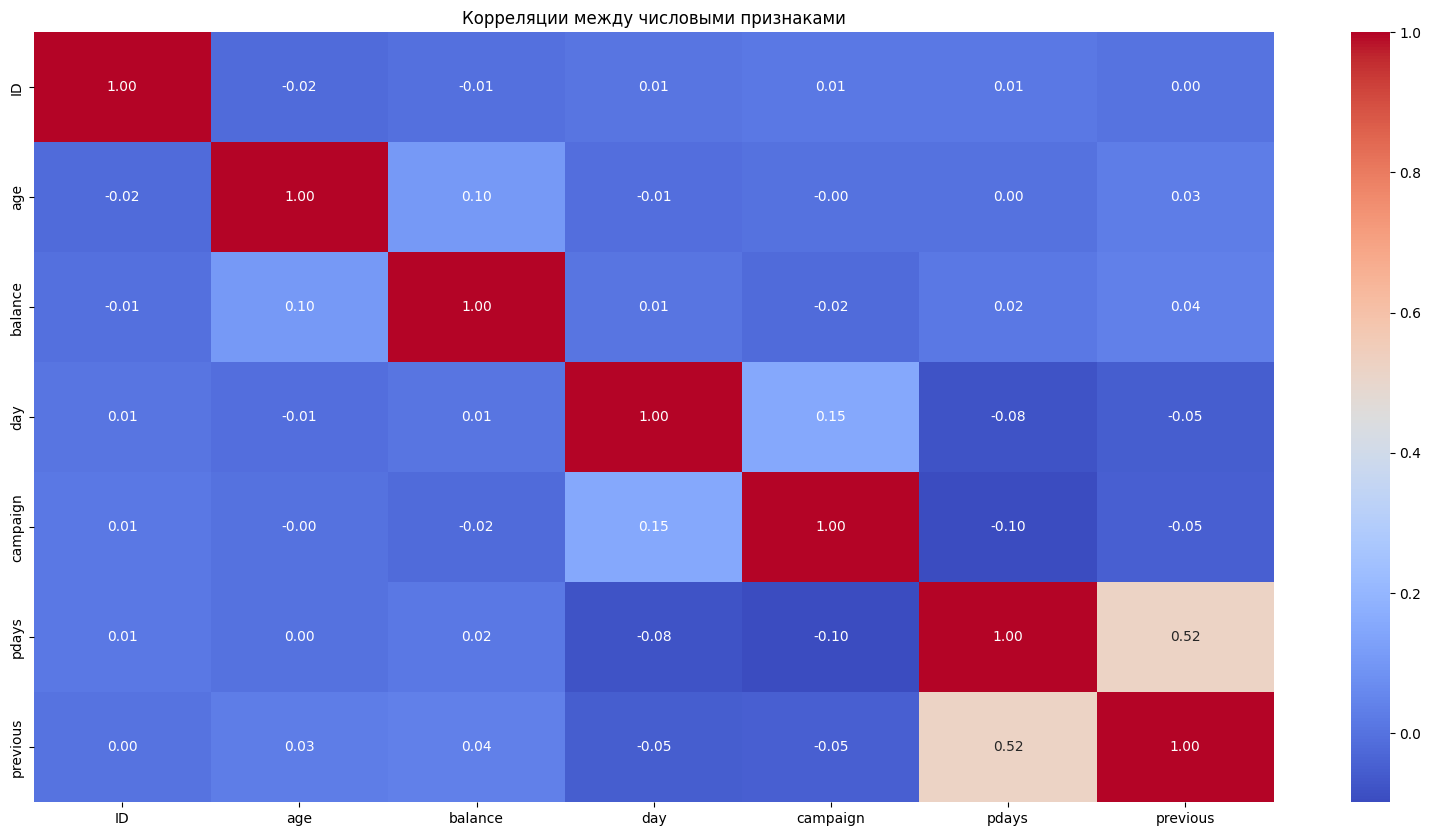

In [328]:
#your code
train_matr = data_train.select_dtypes(include=["float64", "int64"])
corr = train_matr.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляции между числовыми признаками")
plt.show()



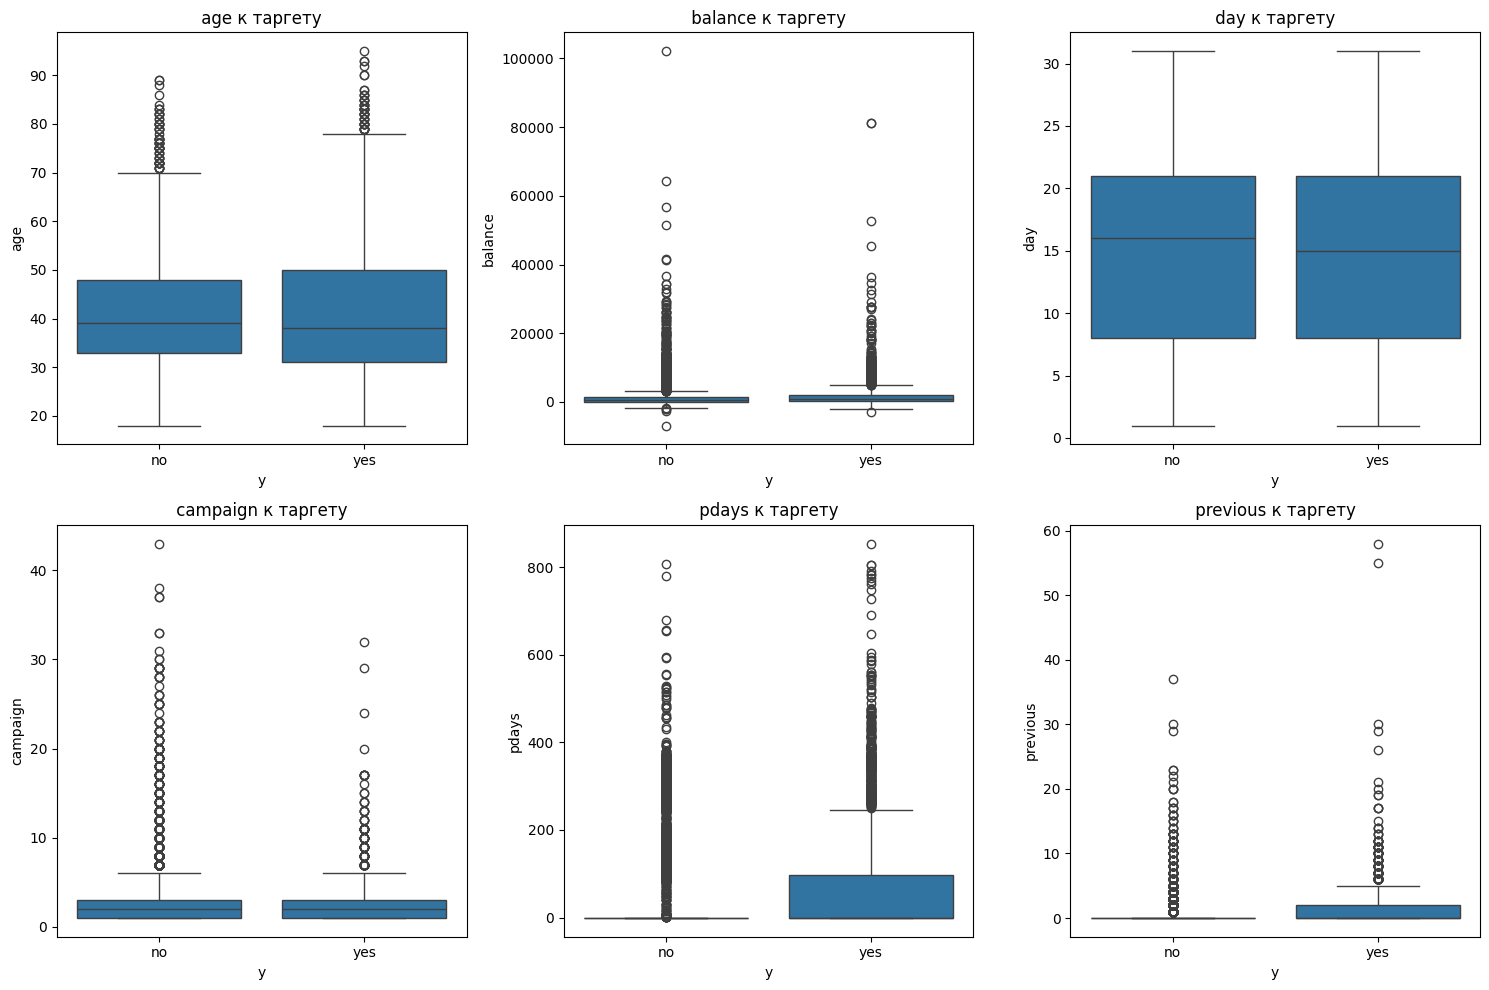

In [329]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(data=data_train, x='y', y=feature, ax=axes[i])
    axes[i].set_title(f' {feature} к таргету ')

plt.tight_layout()
plt.show()

### 2. Работа с пропусками(imputing)  

* <b>какими способами можно обработать пропуски:</b>
    - в категориальных переменных
      > ответ тут как правило модой нужно запролнять. т.е. самой частовстречающейся 
    - в числовых переменных
      > ответ тут мндиана\среднее  медиана устойчивее к выбросам
    
* <b>Какие плюсы у того или иного способа</b>

  > овтет тут



In [330]:
data_train.isna().sum()
# ID             int64
# age          float64
# job           object
# marital       object
# education     object
# default       object
# balance      float64
# housing       object
# loan          object
# contact       object
# day            int64
# month         object
# campaign       int64
# pdays          int64
# previous       int64
# poutcome      object
# y             object
# dtype: object

ID             0
age          588
job            0
marital        0
education      0
default        0
balance        5
housing        0
loan           0
contact        0
day            0
month          5
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

* <b>Заполните пропуски способом, который считаете нужным</b>

In [331]:

# your_code

numeric_features = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

my_imputer = ColumnTransformer(
    transformers=[
        ("num_imput", SimpleImputer(strategy="median"), numeric_features),
        ("cat_imput", SimpleImputer(strategy="most_frequent"), categorical_features),
    ],
    remainder='passthrough',  
    verbose_feature_names_out=False
)

### 3. Статистика



* <b>Что такое t-test/z-test и для чего он применяется?</b>

> ответ тут статистические тесты. т тест приминяют когда известно стандартное отклонение. зет тест. когда неизвестно 

In [332]:
from scipy.stats import ttest_ind

* <b>Примените t-test для проверки значимости признака `balance` в разрезе класса</b> и прокомментируйте поулученный результат

In [333]:
#your code
balance_yes = data_train[data_train['y'] == 'yes']['balance']
balance_no = data_train[data_train['y'] == 'no']['balance']
t_stat, p_value = ttest_ind(balance_yes, balance_no, equal_var=True)  

print(f"t-стат {t_stat:.4f}")
print(f"p-value {p_value:.18f}")


t-стат nan
p-value nan


> комментарий по результатам теста. .. т статистика сильно влияет на p-value. т.к. она высока p_value очень маленький. то есть различия между группами занчительны. по сути хватипло бы т статистики и > 2 чтобы принять 1 гипотезу. тогда пи вэлью был бы 0.05. это значение считается досмтаточно низким риском. 

* Если считаете необходимым, можете описать и остальные фичи стат.тестами. 

### 4. Кодирование категориальных перменных(encoding)

* <b>Для чего нужно кодировать категориальные переменные?</b>
    > ответ тут для того. чтобы обучить модель. ей нужно передать цифры т.к. буквенные значения алгоритм как правило не может принять .
* <b>Какие способы кодирования категориальных переменных вам известно</b>
    > ответ тут OneHotEncoder, Label Encoder,  я для себя выделил эти 2 как основные/ лэйбл - все делает в 1 столбце. 

* <b>Закодируйте переменные соответствующим способом</b>

In [334]:
#your code
my_encoder = ColumnTransformer(
    transformers=[
        ("owanencoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features) # sparse для экономии памяти handle для предотавращения ошибки 
    ],
    remainder = "passthrough",
    verbose_feature_names_out=False
)
    


### 5. Масштабирование данных (Scaling)

* <b>Какие основные Scaler'ы знаете</b>
    > тест стандарт скейлер Преобразует данные так, чтобы среднее = 0, стандартное отклонение = 1.  минмакс скейлер. преобразует данныве в знач от 0 до 1 .. RobustScaler
* <b>Для чего это нужно</b>
    > ответ тут. для того. чтобы модель поняла. что данные в стоблцах стоимось и высота потолков не оденозначны(стоимость повысилась на 10 т.р.... значит и потолок можно повысить на 10 т.р. ) . Чтобы поставить данные в один единиый и понятный диапазон
* <b>Для чего это нужно</b>
    > ответ тут

* Вспомните структуры пройденных нами алгоритмов. Каким алгоритмам необходимы нормализованные данные, а каким  нет?
    > ответ тут не нужно  это деревьям решений. (если спрсят вспомни картинки деревьев) . нужно дя остальных  в собенности для регрессии , KNN в общем для всего что измеряет расстояние. 

* <b>отмасштабируйте свои признаки</b>

In [335]:
# your code
my_scaler = ColumnTransformer(
    transformers=[
        ("StandScaler", StandardScaler(), numeric_features),
    ],
remainder = "passthrough",
verbose_feature_names_out=False
)

In [336]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
import joblib  # Для сохранения модели

# Модели бустинга
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [337]:
# === ШАГ 5: Собираем пайплайн ===
preprocessor = Pipeline([
    ('my_imputer', my_imputer),
    ('my_encoder', my_encoder),
    ('my_scaler', my_scaler)
])

In [338]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor  
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge  # Импорт Ridge для L2-регуляризации
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [339]:
# 

In [340]:
# X_train, y_train = data_train.drop('y', axis=1), data_train['y']

# === ШАГ 6: Проверяем ===
try:
    X_processed = preprocessor.fit_transform(X_train)
    print(f"\n✅ Успешно! Размер после обработки: {X_processed.shape}")
    
    # Можно посмотреть имена фич
    # feature_names = preprocessor.get_feature_names_out()
    # print(f"Колонок на выходе: {len(feature_names)}")
    
except Exception as e:
    print(f"\n❌ Ошибка: {e}")


✅ Успешно! Размер после обработки: (12870, 51)


In [345]:
from sklearn.ensemble import VotingClassifier

In [ ]:
xgb = XGBClassifier(random_state=42, n_estimators=70)
logreg = LogisticRegression(random_state=42, max_iter=1000)  # Замена Ridge на LogisticRegression

voting_model = VotingClassifier(estimators=[("xgb", xgb), ("logreg", logreg)], voting='soft')  # 'soft' для вероятностей


ml_voting = Pipeline([
    ('preprocessor', preprocessor),
    ('voting_model', voting_model)
])


ml_voting.fit(X_train, y_train)


cv_scores = cross_val_score(ml_voting, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
print(f"CV ROC-AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV ROC-AUC: 0.7867 ± 0.0138


In [349]:
if 'data_test' in locals():
    predictions_proba = ml_voting.predict_proba(data_test)[:, 1]  # Вероятность класса 1
    submission = pd.DataFrame({'ID': data_test['ID'], 'Prediction': predictions_proba})
    submission.to_csv('submission.csv', index=False)
    print("Предсказания сохранены в submission.csv")

Предсказания сохранены в submission.csv


In [351]:
with open('voting_model.pkl', 'wb') as f:
    pickle.dump(ml_voting, f)
print("Модель сохранена как 'voting_model.pkl'")

Модель сохранена как 'voting_model.pkl'


### 6.Модели

* Какие знаете модели машинного обучения? В чем плюсы и минусы каждого (🔥)
    > ответ тут логистическая регрессия(быстраяб менее точнаяб чувствительна к выбросам), рандом форест(устойчив к переобучениюб,- зависит от параметров которые нужно устанавливать порой эмпирическим путем, что может требовать многократного перезапууска, что не хорошо при раьботе с большими данными ),
Бустинг(лучшая точность - медленный, не параллельный),
 КНН( ни туда ни сюда)
 бэггинг( бутстрап по сути.)

* __Boosting vs Bagging__. В чем разница, плюсы и минусы каждого друг перед другом.(🔥🔥🔥)
    > ответ тут Godzilla vs Kong 
    бэгинг +++ параллельный, сложно переобучить т.к. создает много "деревьев"  и усреднят знач можно дополнить Л2 (бридж) ругуляризацией
    бэгинг - менее точный
    бустинг +++ самый точный из алгоритмов. за счет принципа работы. 
    бустинг --- последовательный и долгий. 

* Выберите модели, которые считаете нужными. Тюнинг, валидирование результата и отбор признаков на вас. Тестовая выборка ждет вас на стримлите, метрика качества __ROC-AUC__, но это всего лишь одна метрика, по которой мы будем оценивать эффективность. Можете смотреть множество метрик, это полезно, не стесняйтесь :)

* Как можно попытаться проинтепретировать ROC-AUC? PR-AUC? (🔥)

### 7.Классификация

In [ ]:
import pandas as pd

assert len(pd.read_csv('data/test.csv')) == len(pd.read_csv('data/submission.csv')), \
    'Lengths of files are mismatch!'